In [1]:
!pip install alpha_vantage

In [2]:
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
import matplotlib.pyplot as plt
import pandas as pd
import sys
import numpy as np
import time
from operator import methodcaller
import requests
import datetime

In [3]:
api_keys = ['Q2VLL7ZMEK051QX3','AU8V87VFTWGSVYDS','82HGBJTY5UEJJXHM','RD5ZEPD8IWT86VGP','9O3TF6QMDGGVHQSF','4R5NDTM0D1HKQA9V','MY2FVAV6O66MO17X','XCMSFDTYUZGLCJBS',
            'XUUREGTQG152WYG9','V1C6EMEAHD6S7PID']
api_counter = 0

In [4]:
def get_api_key(): # each API key is rate limited on how many API calls can be made per minute; therefore, use rotation of keys to prevent throttling
  global api_counter
  api_counter = (api_counter+1)%len(api_keys)
  return api_keys[api_counter]

In [5]:
get_api_key()

'AU8V87VFTWGSVYDS'

In [6]:
symbols_A = ['AMZN', 'NFLX', 'BABA']
symbols_B = ['SPOT', 'JD', 'TSLA']
symbols_C = ['SBUX', 'FB', 'AAPL']
symbols_D = ['GSK', 'UA']
symbols_E = ['PM', 'GOOG']
symbols_F = ['DIS', 'GE'] #, 'LYFT'
interval = '15min'
intervalSMA = 'daily'
time_period = 100
series_type = 'close'
MA_period = 20
past_days_short = 10
past_days_long = 200

In [7]:
tsdaily_dfs, sma_dfs, bbands_dfs, pe_ratio_dfs = {}, {}, {}, {}

In [21]:
# symbols = ['AMZN','PM','SBUX','DIS']
symbols = ['AAPL','AXP','GOOG','META','NVDA','AMZN','PM','SBUX','DIS']

In [22]:
def generate_dfs(symbol):
  print(symbol)
  # replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
  function = 'EARNINGS'
  url = f'https://www.alphavantage.co/query?function={function}&symbol={symbol}&apikey={get_api_key()}'
  r = requests.get(url)
  data = r.json()
  earnings_df = pd.DataFrame.from_records(data['quarterlyEarnings'])

  # replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
  function = 'TIME_SERIES_DAILY'
  outputsize = 'full'
  url = f'https://www.alphavantage.co/query?function={function}&symbol={symbol}&apikey={get_api_key()}&outputsize={outputsize}'
  r = requests.get(url)
  data = r.json()
  tsdaily_df = pd.DataFrame.from_records(data['Time Series (Daily)']).transpose()

  for col in tsdaily_df.columns:
    tsdaily_df[col] = pd.to_numeric(tsdaily_df[col])
  tsdaily_df.index = pd.to_datetime(tsdaily_df.index)

  for col in earnings_df.columns[2:]:
    earnings_df[col] = pd.to_numeric(earnings_df[col], errors='coerce')
  for col in earnings_df.columns[:2]:
    earnings_df[col] = pd.to_datetime(earnings_df[col], errors='coerce')

  earnings_df = earnings_df.set_index('fiscalDateEnding').sort_index()
  pe_ratio_df = pd.merge_asof(earnings_df, tsdaily_df[['4. close']], left_index=True, right_index=True, direction='nearest').sort_index(ascending=False)
  pe_ratio_df['PE Ratio'] = pe_ratio_df['4. close']/pe_ratio_df['reportedEPS']/4
  pe_ratio_df['PE Ratio (SMA)'] = pe_ratio_df['4. close']/pe_ratio_df['reportedEPS']/4
  pe_ratio_df.index = pd.to_datetime(pe_ratio_df.index)
  ctr = 0
  for idx, row in pe_ratio_df.iterrows():
    try:
      pe_ratio_df.iloc[ctr,7] = (pe_ratio_df.iloc[ctr,6]+pe_ratio_df.iloc[ctr+1,6]+pe_ratio_df.iloc[ctr+2,6]+pe_ratio_df.iloc[ctr+3,6])/4
    except:
      print(ctr)
      break
    ctr += 1
  pe_ratio_df = pe_ratio_df.sort_index()

  tsdaily_df = tsdaily_df.sort_index(ascending=False)
  tsdaily_df['TP'] = (tsdaily_df['2. high']+tsdaily_df['3. low']+tsdaily_df['4. close'])/3
  tsdaily_df['S.D.'] = tsdaily_df['TP']
  tsdaily_df['SMA'] = tsdaily_df['TP']
  ctr = 0
  for idx, row in tsdaily_df.iterrows():
    try:
      tsdaily_df.iloc[ctr,6] = tsdaily_df.iloc[ctr:ctr+20,5].std()
      tsdaily_df.iloc[ctr,7] = tsdaily_df.iloc[ctr:ctr+20,5].mean()
    except:
      print(ctr)
      break
    ctr += 1
  tsdaily_df = tsdaily_df.sort_index()
  tsdaily_df['BOLU'] = tsdaily_df['SMA'] + 2*tsdaily_df['S.D.']
  tsdaily_df['BOLD'] = tsdaily_df['SMA'] - 2*tsdaily_df['S.D.']
  tsdaily_df['state'] = 0
  for idx, row in tsdaily_df.iterrows():
    if row['4. close'] < row['BOLD']:
      tsdaily_df.loc[idx,'state'] = -1
    elif row['4. close'] > row['BOLU']:
      tsdaily_df.loc[idx,'state'] = 1

  return tsdaily_df, pe_ratio_df

In [23]:
for symbol in symbols:
  tsdaily_dfs[symbol], pe_ratio_dfs[symbol] = generate_dfs(symbol)

AAPL
107
AXP
107
GOOG
35
META
43
NVDA
95
AMZN
102
PM
59
SBUX
107
DIS
107


In [24]:
tsdaily_dfs.keys()

dict_keys(['AAPL', 'AXP', 'GOOG', 'META', 'NVDA', 'AMZN', 'PM', 'SBUX', 'DIS'])

In [25]:
def plot_graph(symbol, start_date = '2021-01-01', end_date = datetime.date.today()):
  step = 30

  fig, ax1 = plt.subplots(figsize=(40,8))


  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
  ax2.plot(pe_ratio_dfs[symbol]['PE Ratio'].loc[start_date: end_date],label = 'PE',color='C7',linewidth=3)
  ax2.plot(pe_ratio_dfs[symbol]['PE Ratio (SMA)'].loc[start_date: end_date],label = 'PE (SMA)',color='C6',linewidth=3)

  ax1.plot(tsdaily_dfs[symbol]['4. close'].loc[start_date: end_date],label = 'Daily Price',color='C4')
  ax1.plot(tsdaily_dfs[symbol]['SMA'].loc[start_date: end_date],label = 'Mid',color='C3')
  ax1.plot(tsdaily_dfs[symbol]['BOLU'].loc[start_date: end_date],label = 'Up',color='C2')
  ax1.plot(tsdaily_dfs[symbol]['BOLD'].loc[start_date: end_date],label = 'Low',color='C1')

  plt.xticks(list(tsdaily_dfs[symbol][start_date: end_date].index)[::step],rotation=0)
  # plt.yticks(np.arange(min(temp_df.min(axis=None)), max(temp_df.max(axis=None)) + 5, 5))
  for i in list(tsdaily_dfs[symbol][start_date: end_date].index)[::step]:
      plt.axvline(x=i,ls='--',color='lightgrey')

  ax1.set_ylabel(symbol + ' Stock Price')
  ax1.legend(loc='lower right')
  ax2.legend()
  ax2.set_ylabel(symbol + ' PE')
  plt.show()

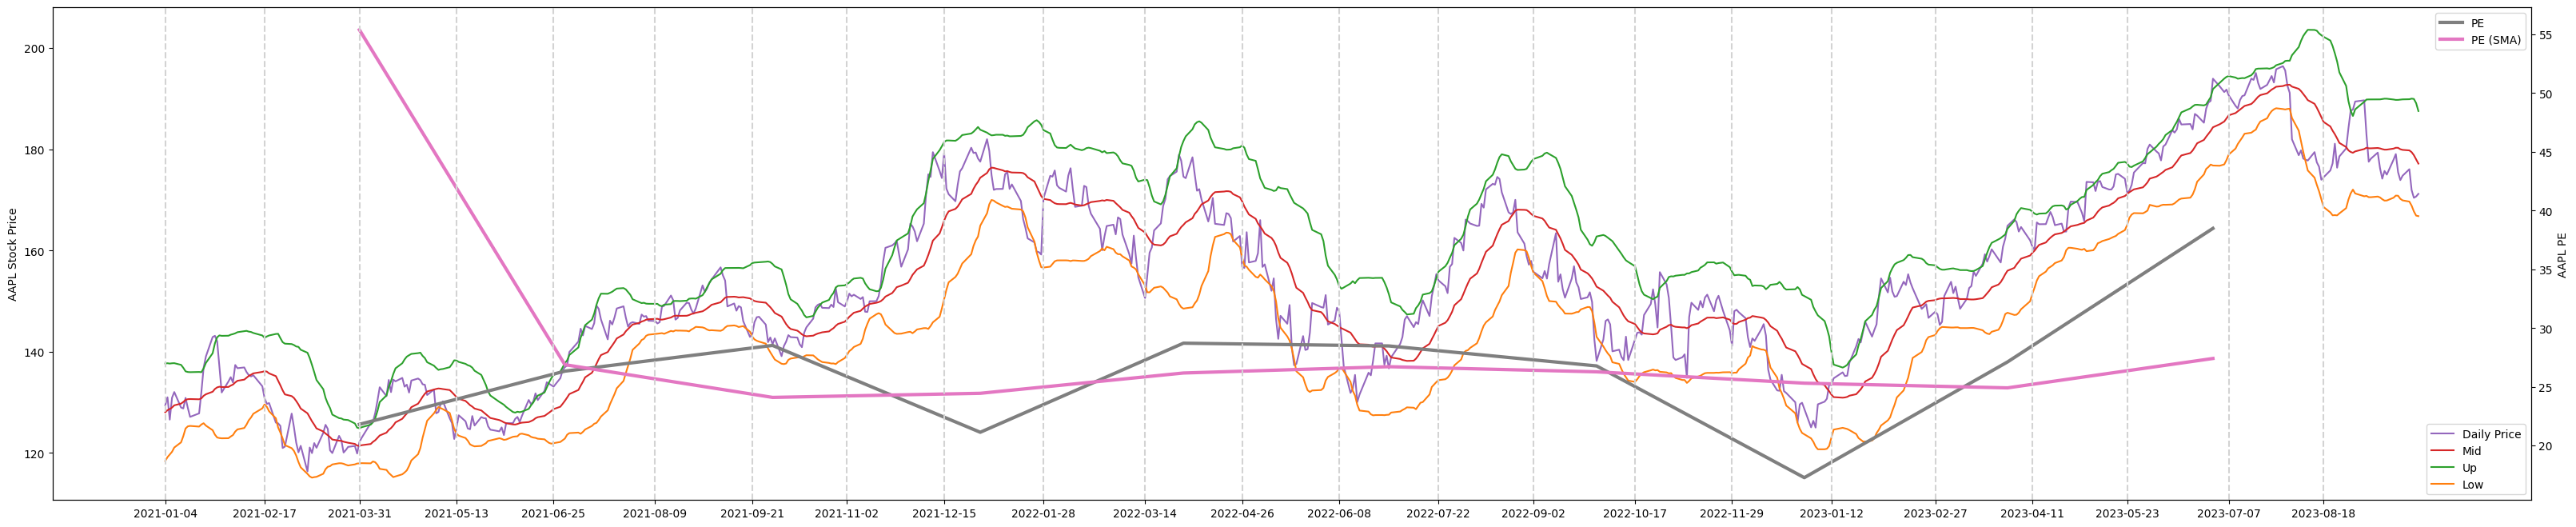

In [ ]:
plot_graph('AAPL')

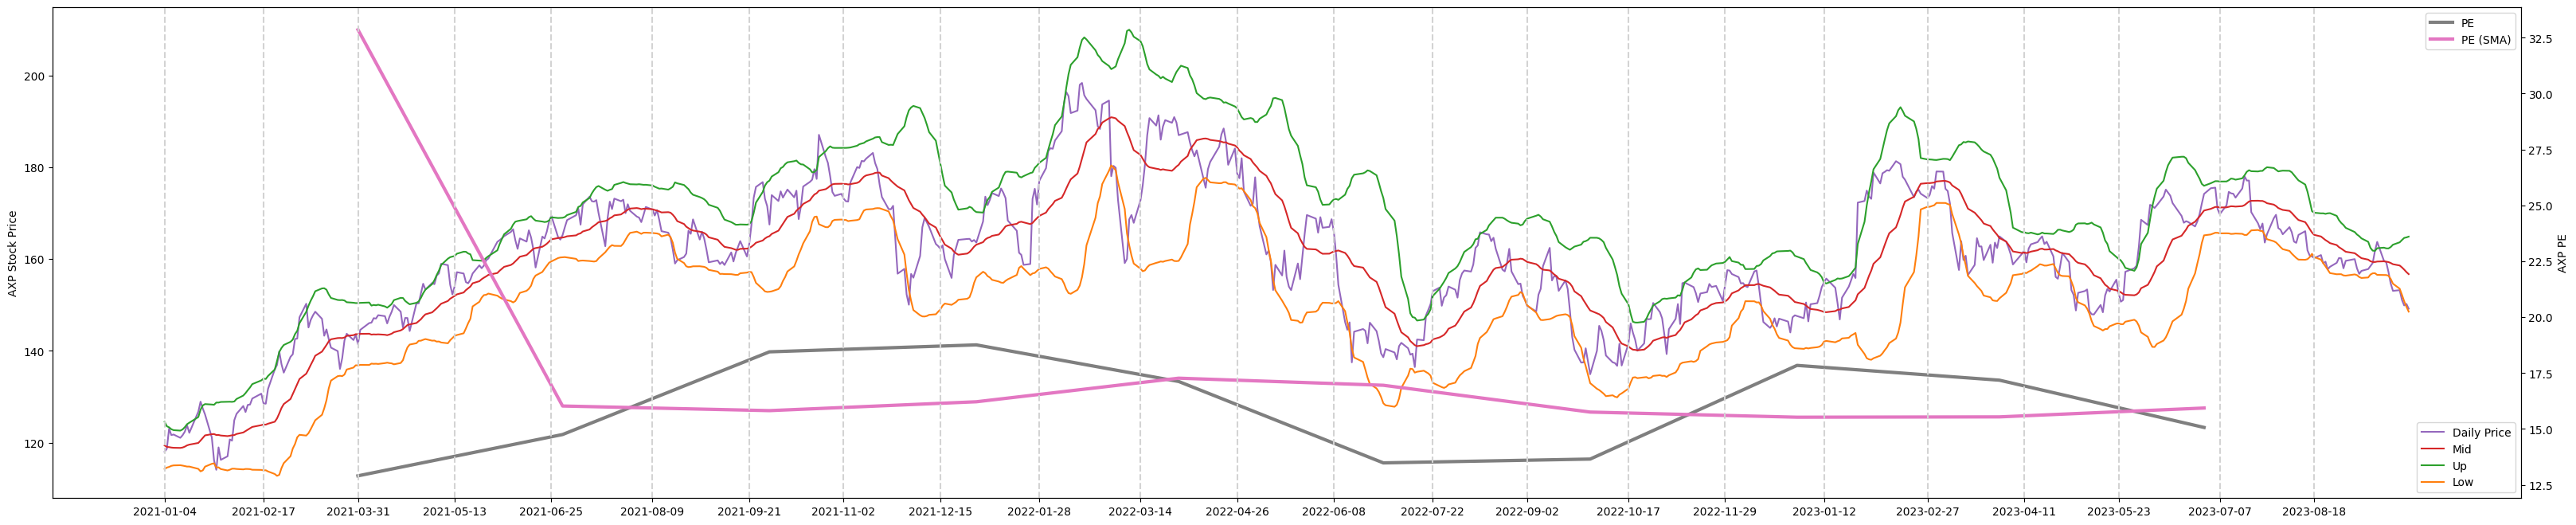

In [ ]:
plot_graph('AXP','2021-01-01')

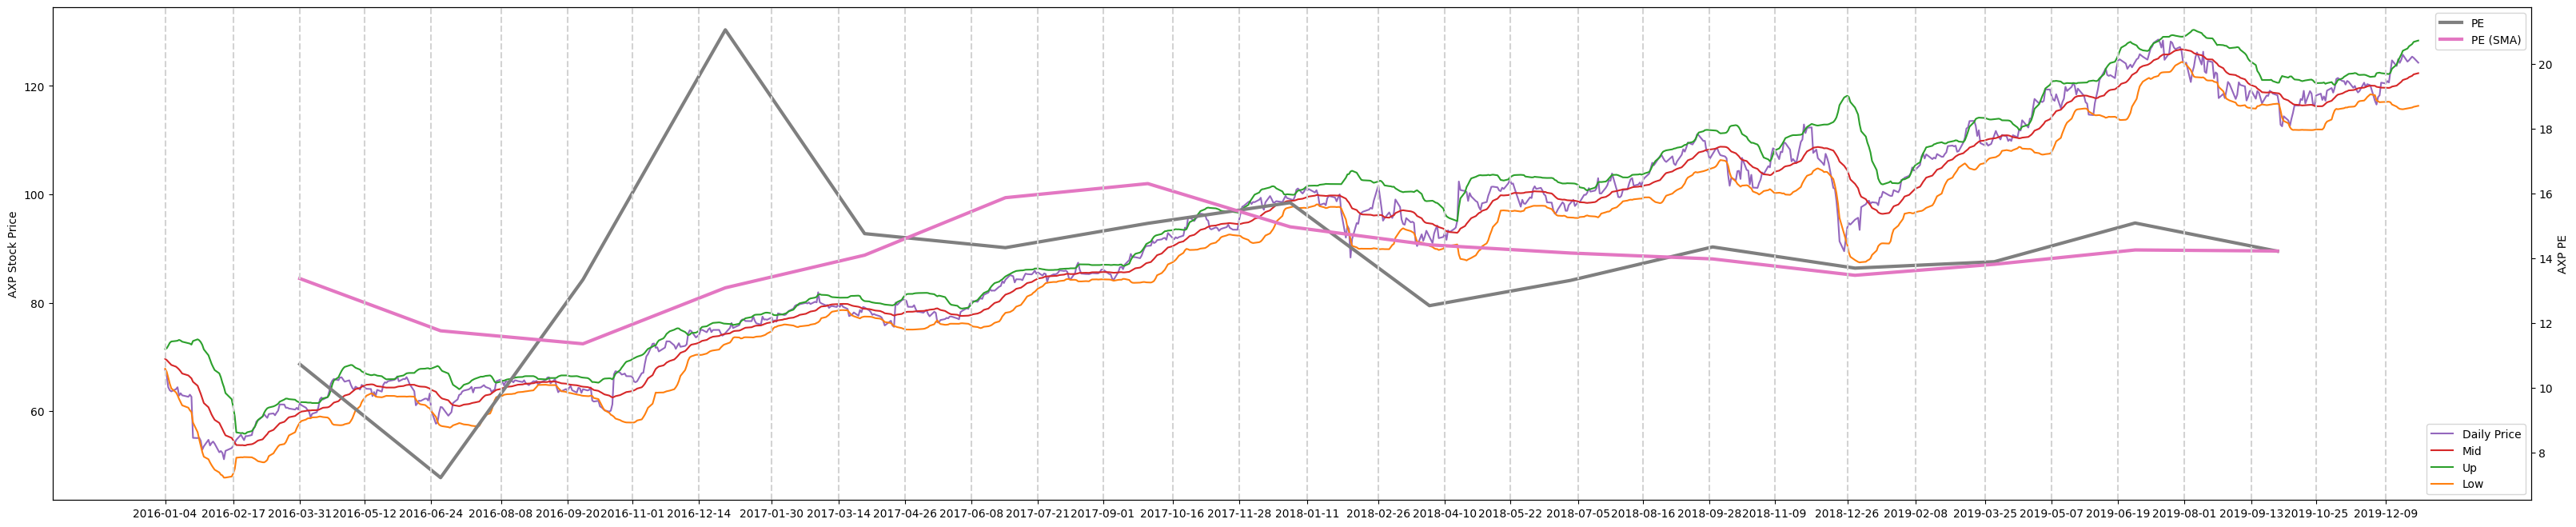

In [ ]:
plot_graph('AXP','2016-01-01','2019-12-30')

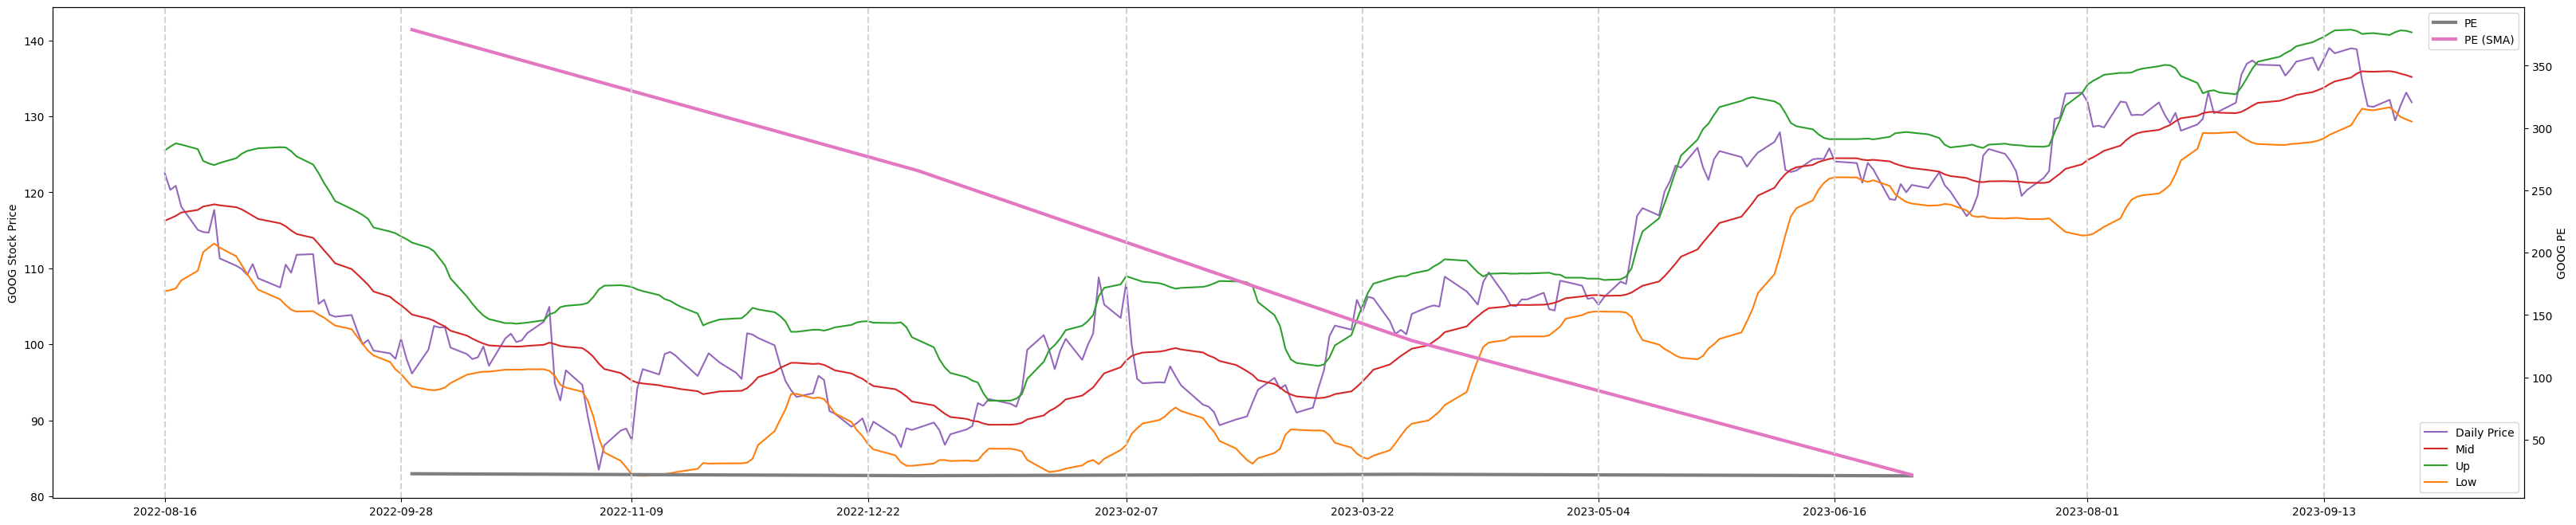

In [ ]:
plot_graph('GOOG','2022-08-16')

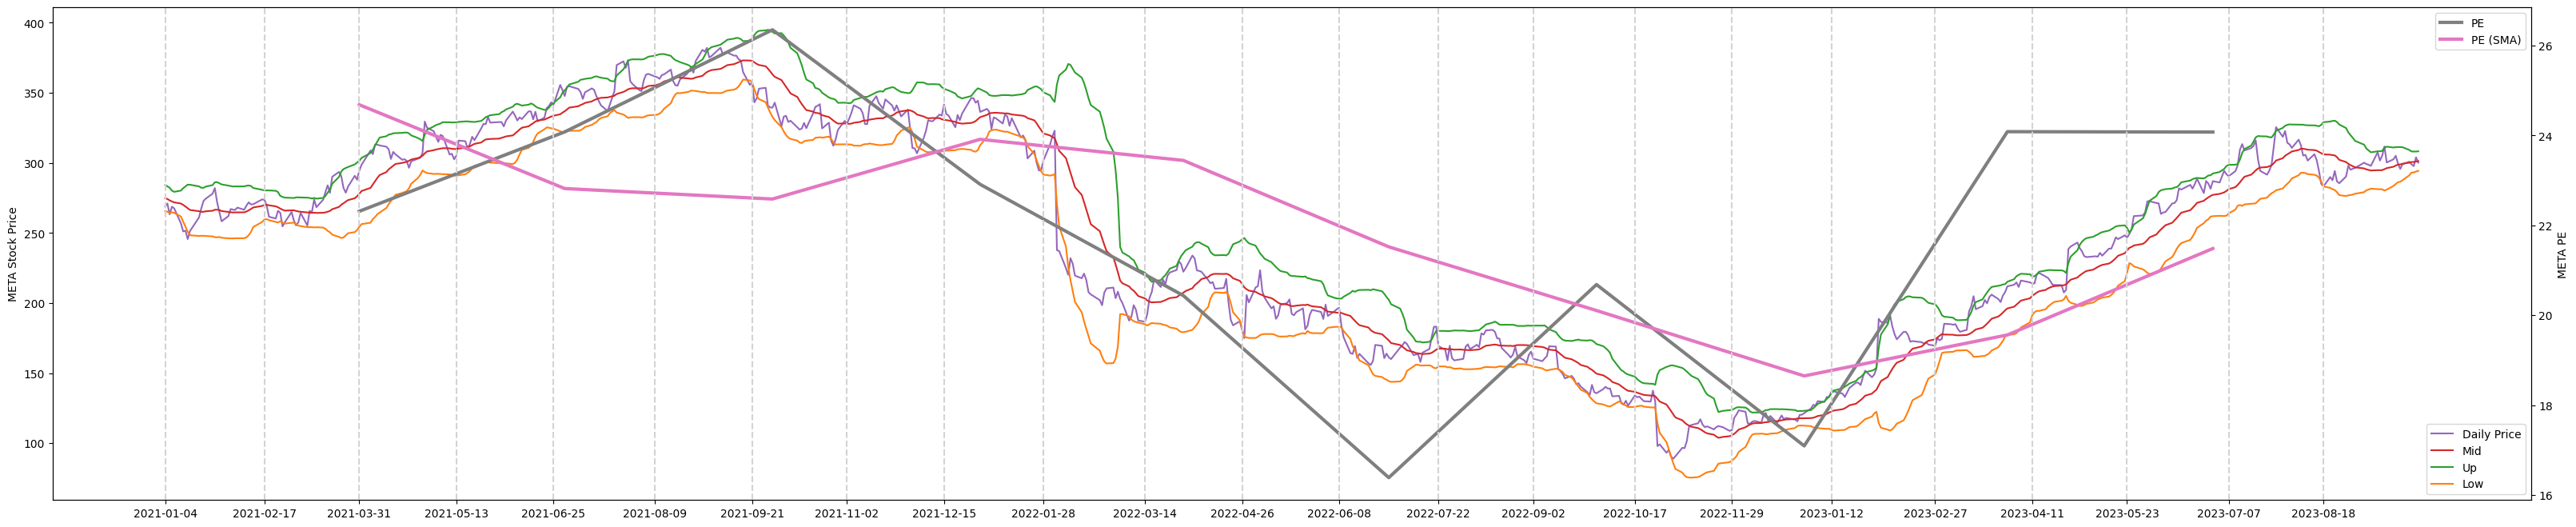

In [ ]:
plot_graph('META','2021-01-01')

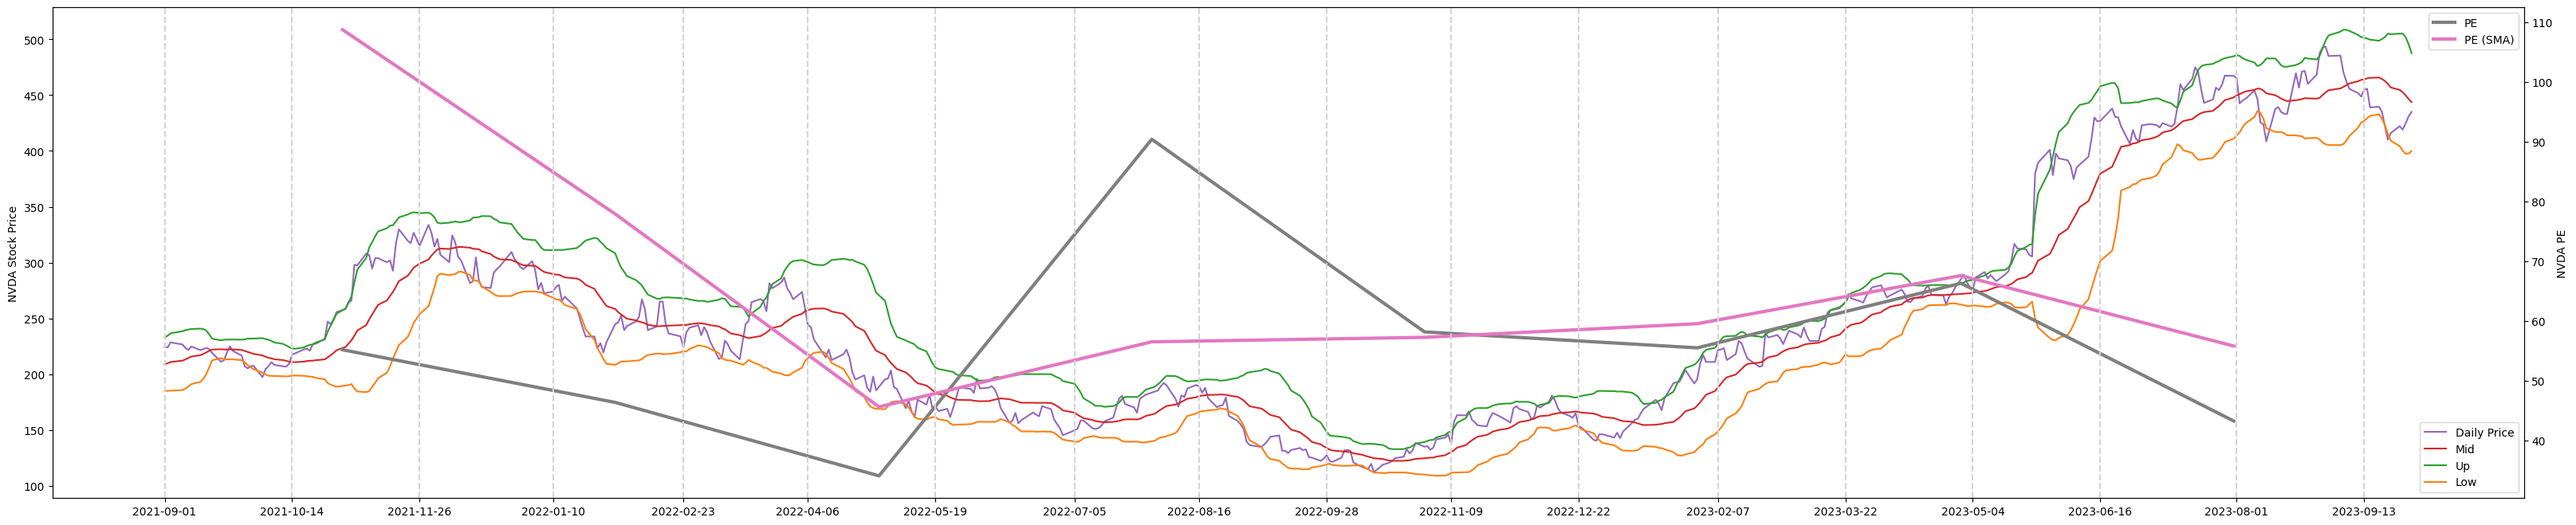

In [ ]:
plot_graph('NVDA','2021-09-01')

In [ ]:
# calculate Bollinger squeeze manually using SMA, since the Bollinger band is off for few of the stocks (works fine only for AAPL and AXP)
# https://www.britannica.com/money/bollinger-bands-indicator
# https://www.investopedia.com/articles/technical/04/030304.asp

In [ ]:
tsdaily_df = tsdaily_dfs['AXP']
tsdaily_df

In [82]:
def create_buy_sell_pairs(symbol, start_date = '2019-01-01', end_date = datetime.date.today()):
  curr_state = 0
  buy_sell_pairs = []
  curr_buy = None
  for idx, row in tsdaily_dfs[symbol]['2021-01-01':].iterrows():
    if row['state'] == -1 and curr_state == 0:
      curr_buy = (idx,row['4. close'])
      curr_state = -1
    elif row['state'] == 1 and curr_state == -1:
      curr_sell = (idx,row['4. close'])
      buy_sell_pairs.append((curr_buy,curr_sell))
      curr_state = 0
  return buy_sell_pairs

In [83]:
buy_sell_pairs = {}
for symbol in symbols:
  buy_sell_pairs[symbol] = create_buy_sell_pairs(symbol)

In [71]:
buy_sell_net= {}
for symbol, buy_sell_pair in buy_sell_pairs.items():
  buy_sell_net[symbol] = sum([s[1] for b,s in buy_sell_pair]) - sum([b[1] for b,s in buy_sell_pair])

In [72]:
buy_sell_net

{'AAPL': 13.670000000000073,
 'AXP': 17.11999999999989,
 'GOOG': 8.399999999999991,
 'META': -147.98000000000002,
 'NVDA': -267.36999999999944,
 'AMZN': -153.88999999999942,
 'PM': 0.32000000000005,
 'SBUX': 4.360000000000014,
 'DIS': -23.910000000000082}

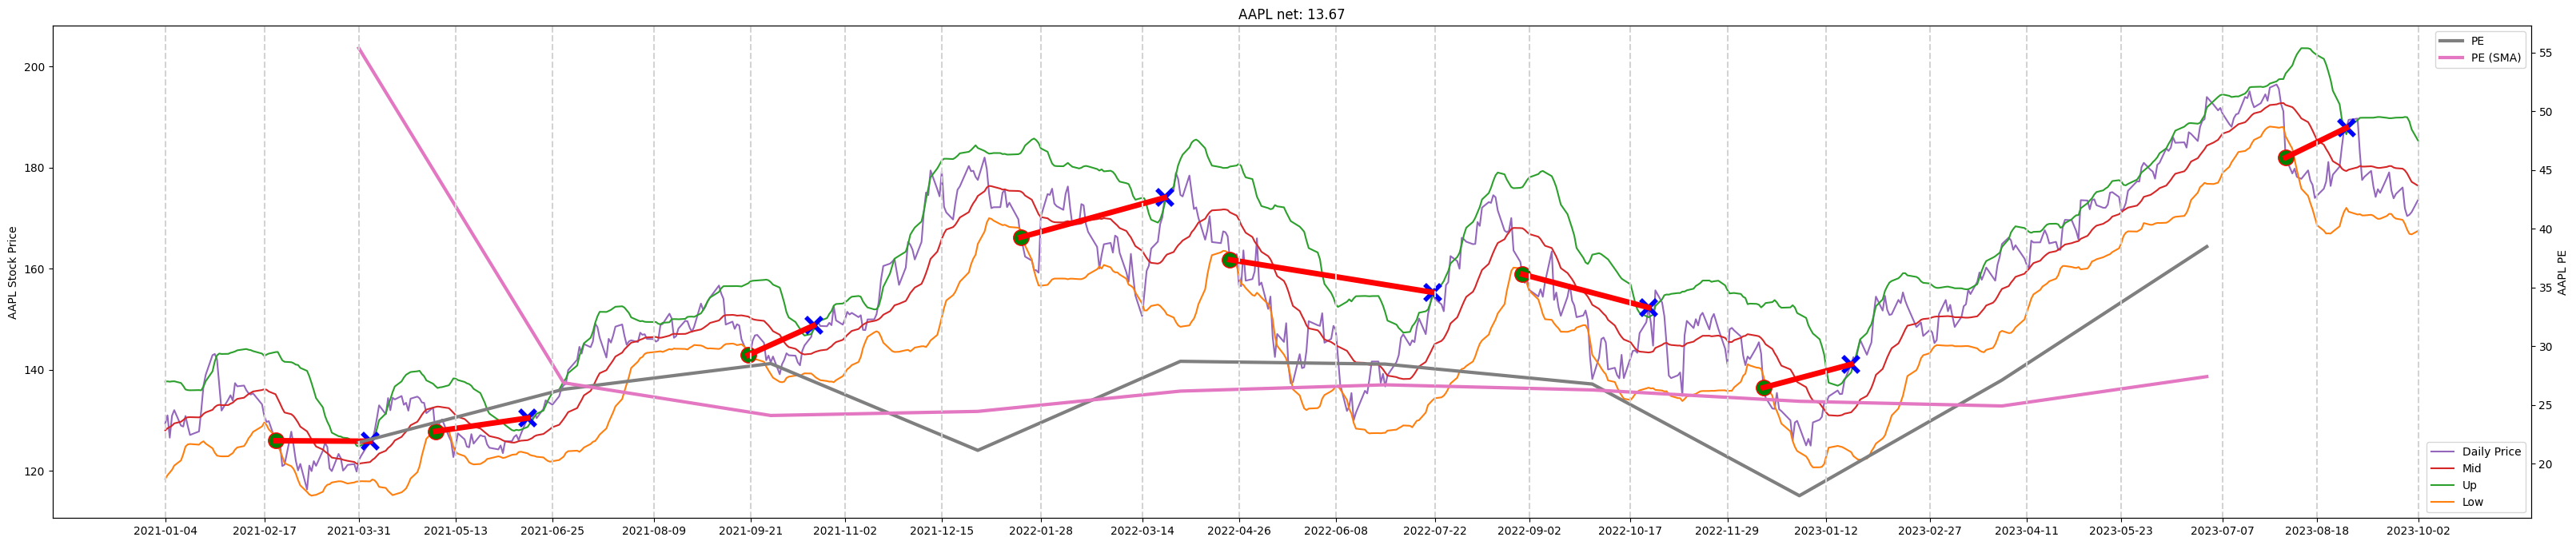

In [80]:
def plot_graph_enhanced(symbol, start_date = '2021-01-01', end_date = datetime.date.today()):
  step = 30

  fig, ax1 = plt.subplots(figsize=(40,8))


  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
  ax2.plot(pe_ratio_dfs[symbol]['PE Ratio'].loc[start_date: end_date],label = 'PE',color='C7',linewidth=3)
  ax2.plot(pe_ratio_dfs[symbol]['PE Ratio (SMA)'].loc[start_date: end_date],label = 'PE (SMA)',color='C6',linewidth=3)

  ax1.plot(tsdaily_dfs[symbol]['4. close'].loc[start_date: end_date],label = 'Daily Price',color='C4')
  ax1.plot(tsdaily_dfs[symbol]['SMA'].loc[start_date: end_date],label = 'Mid',color='C3')
  ax1.plot(tsdaily_dfs[symbol]['BOLU'].loc[start_date: end_date],label = 'Up',color='C2')
  ax1.plot(tsdaily_dfs[symbol]['BOLD'].loc[start_date: end_date],label = 'Low',color='C1')

  plt.xticks(list(tsdaily_dfs[symbol][start_date: end_date].index)[::step],rotation=0)
  # plt.yticks(np.arange(min(temp_df.min(axis=None)), max(temp_df.max(axis=None)) + 5, 5))
  for i in list(tsdaily_dfs[symbol][start_date: end_date].index)[::step]:
      plt.axvline(x=i,ls='--',color='lightgrey')

  for b,s in buy_sell_pairs[symbol]:
    ax1.plot(b[0], b[1], marker="o", markersize=14, markeredgecolor="red", markerfacecolor="green")
    ax1.plot(s[0], s[1], marker="x", markersize=14, markeredgecolor="blue", markerfacecolor="blue",markeredgewidth=4)
    ax1.plot((b[0], s[0]),(b[1], s[1]),lw = 5, color = 'red')

  ax1.set_ylabel(symbol + ' Stock Price')
  ax1.legend(loc='lower right')
  ax1.set_title(f'{symbol} net: {buy_sell_net[symbol]:.2f}')
  ax2.legend()
  ax2.set_ylabel(symbol + ' PE')
  plt.show()
plot_graph_enhanced('AAPL')

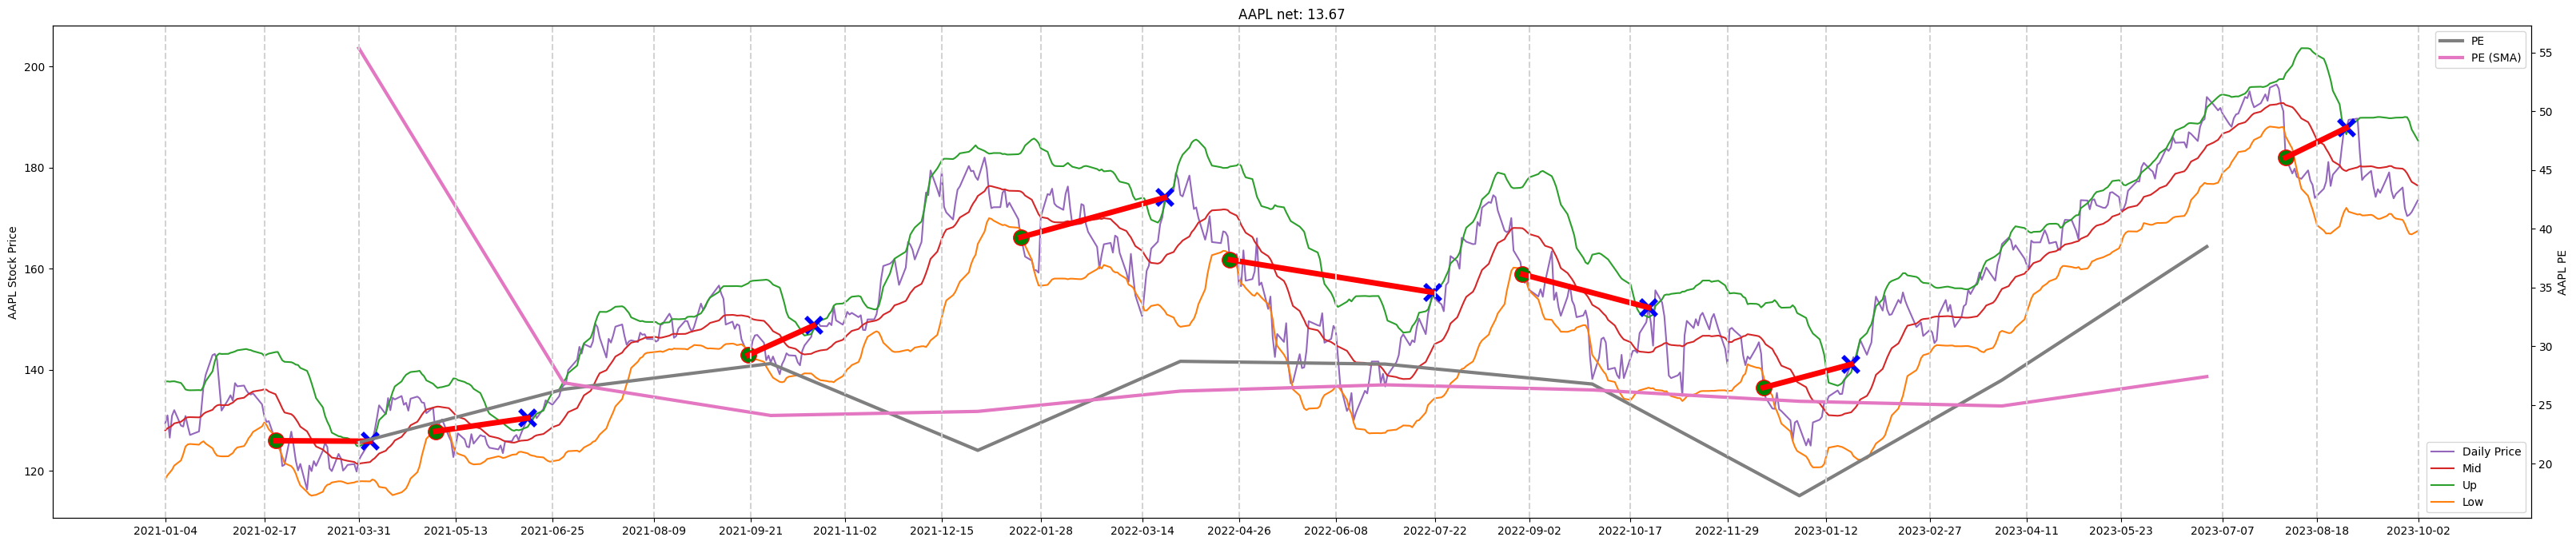

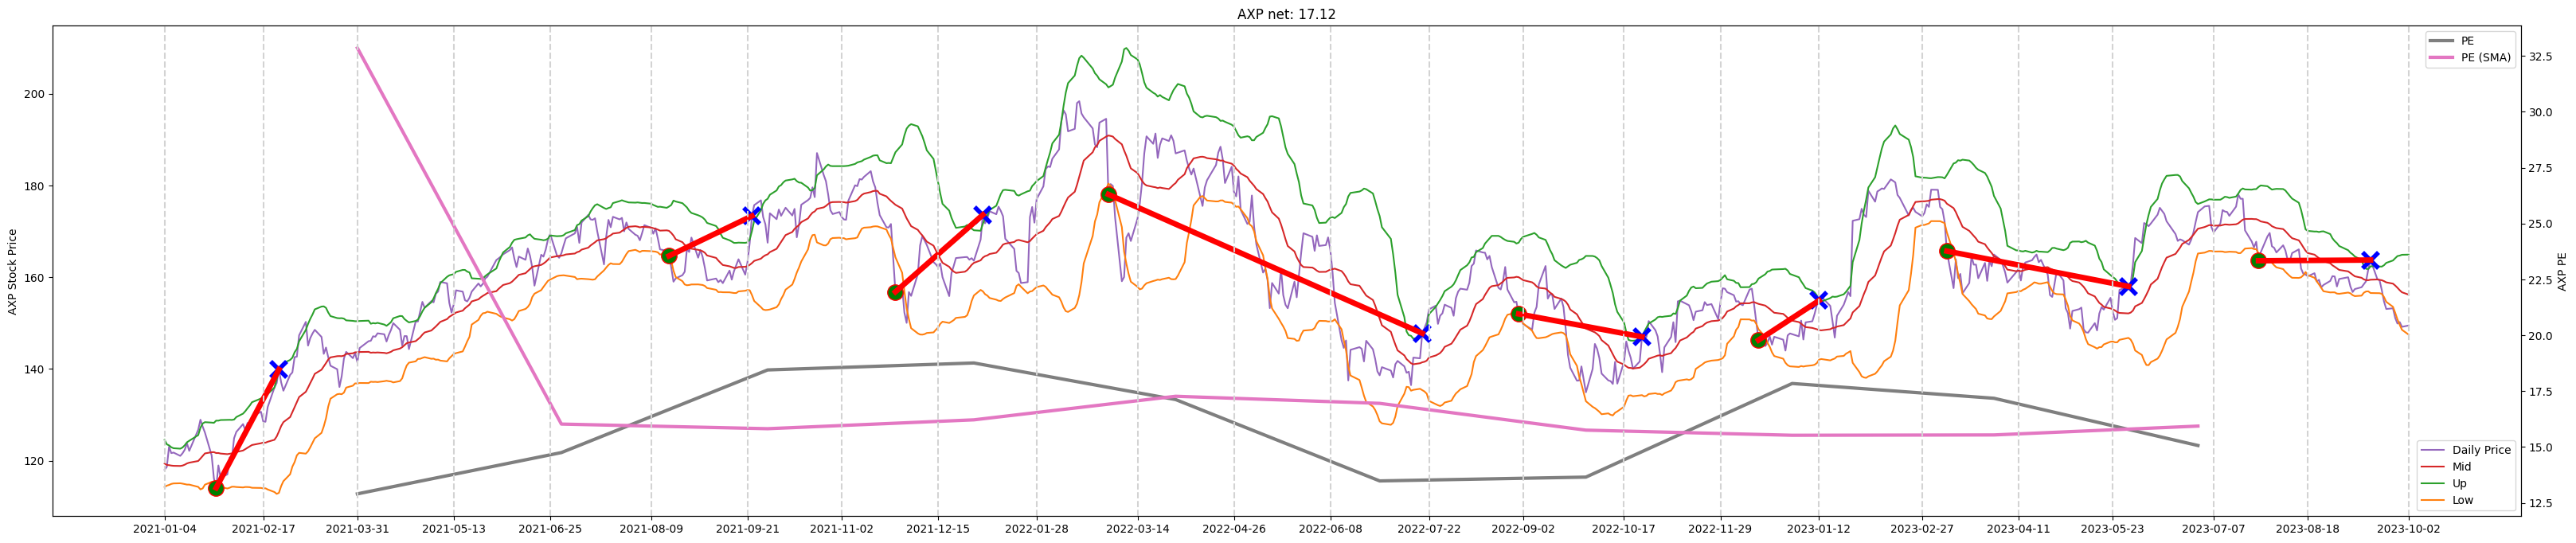

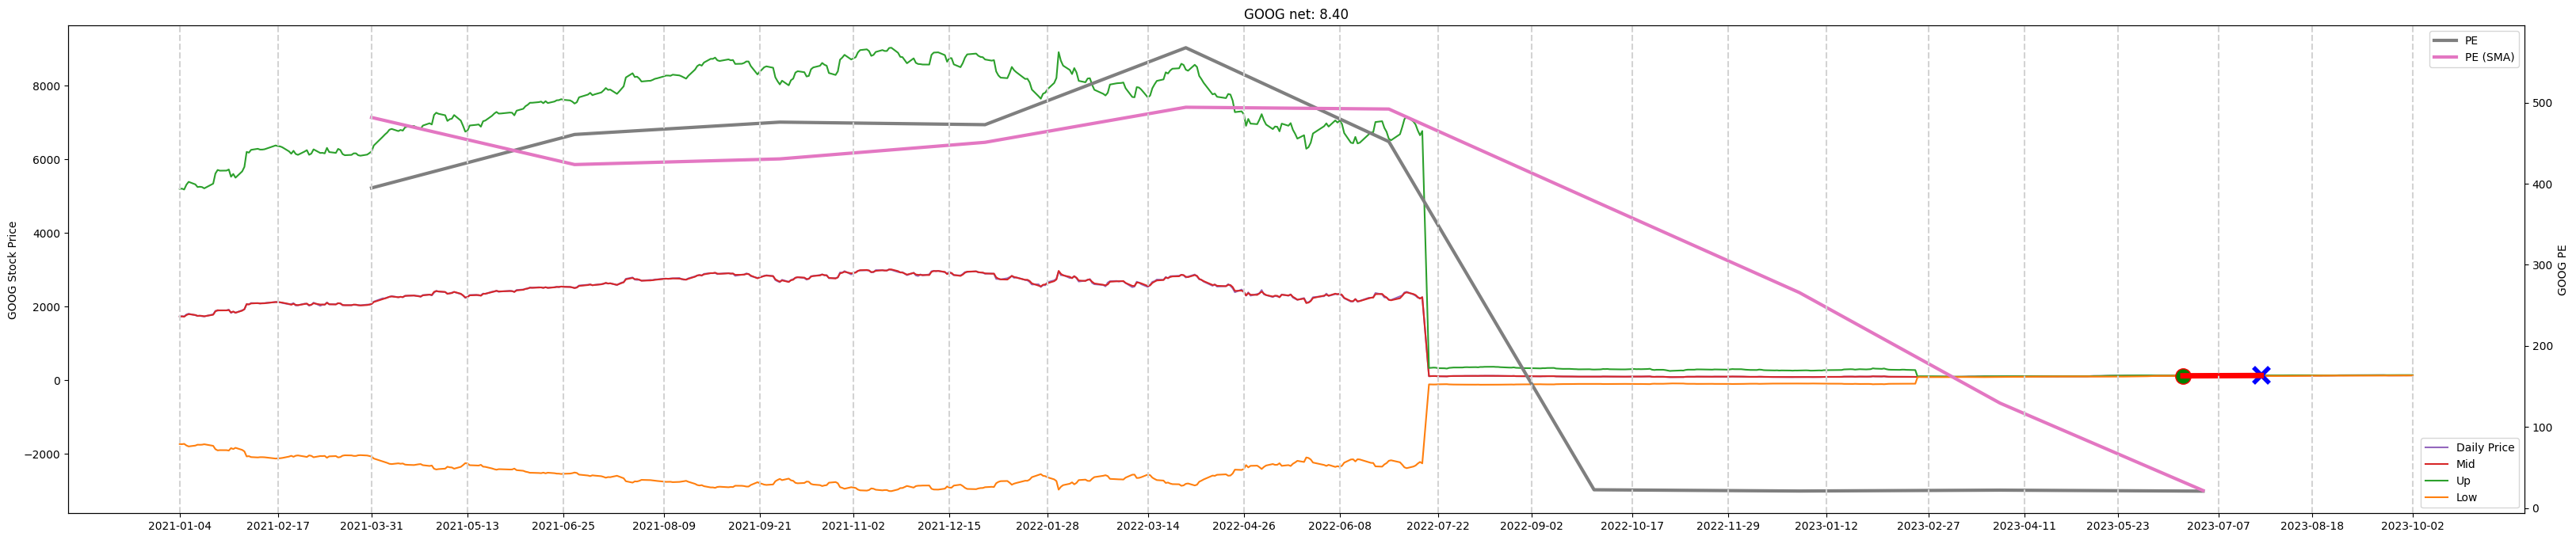

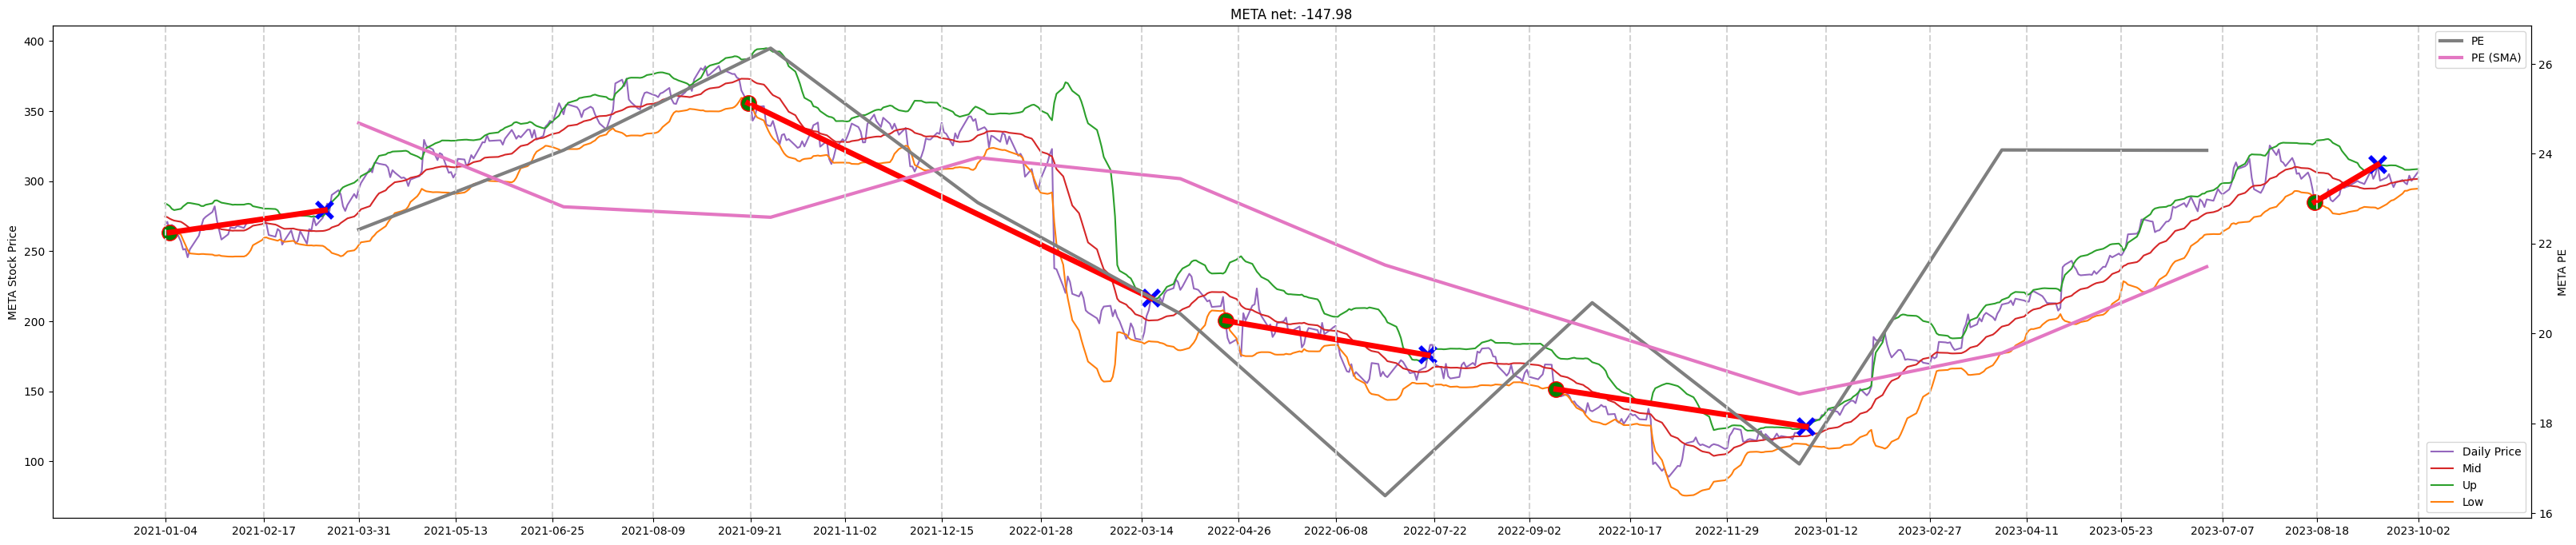

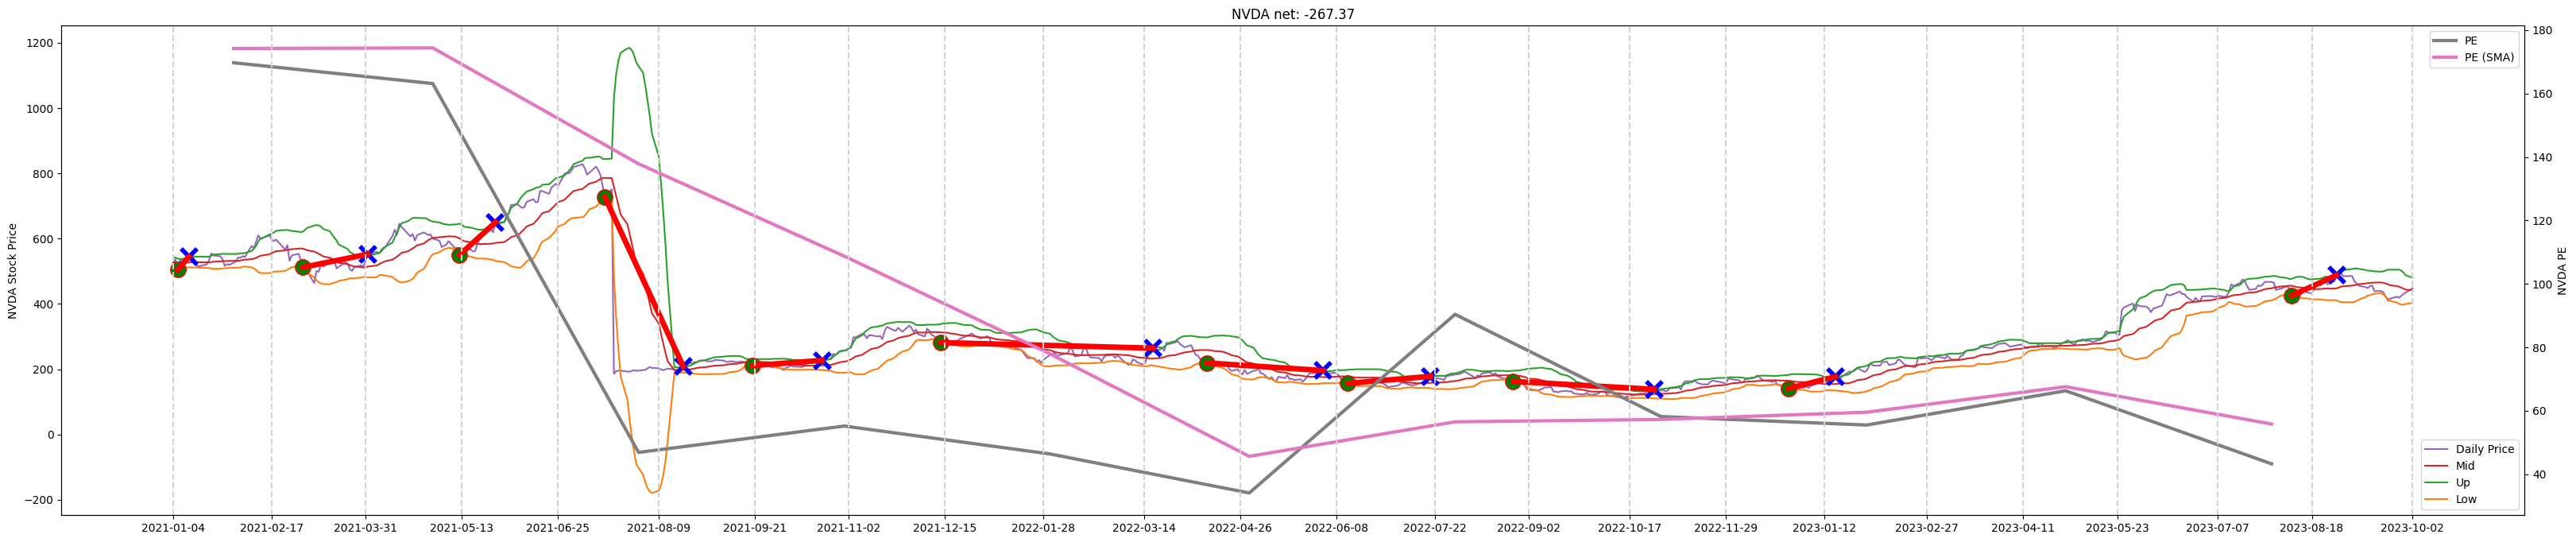

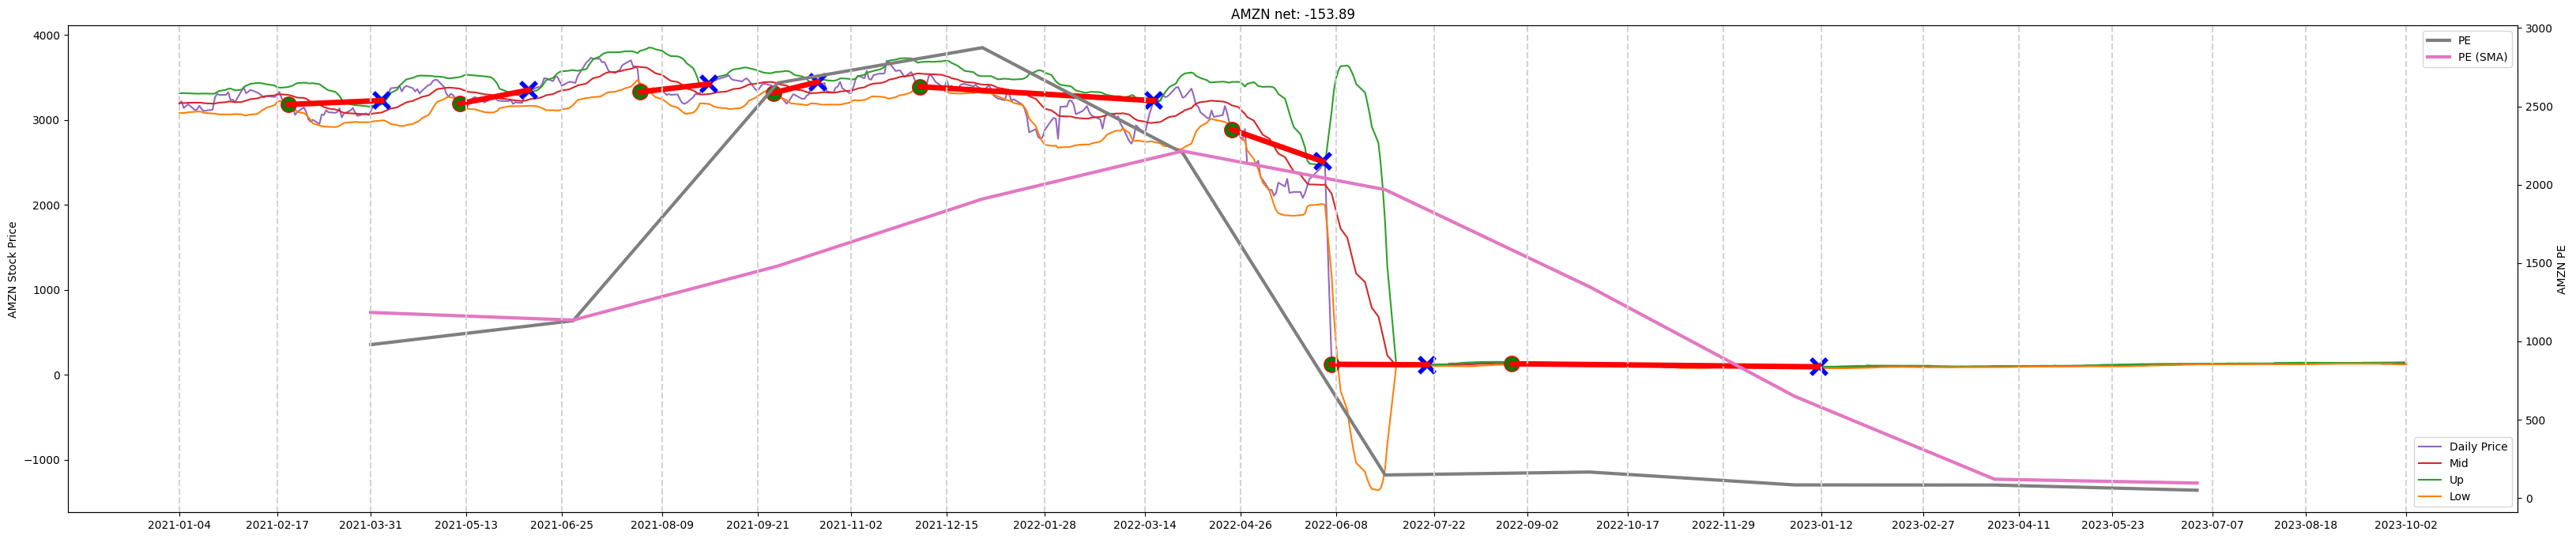

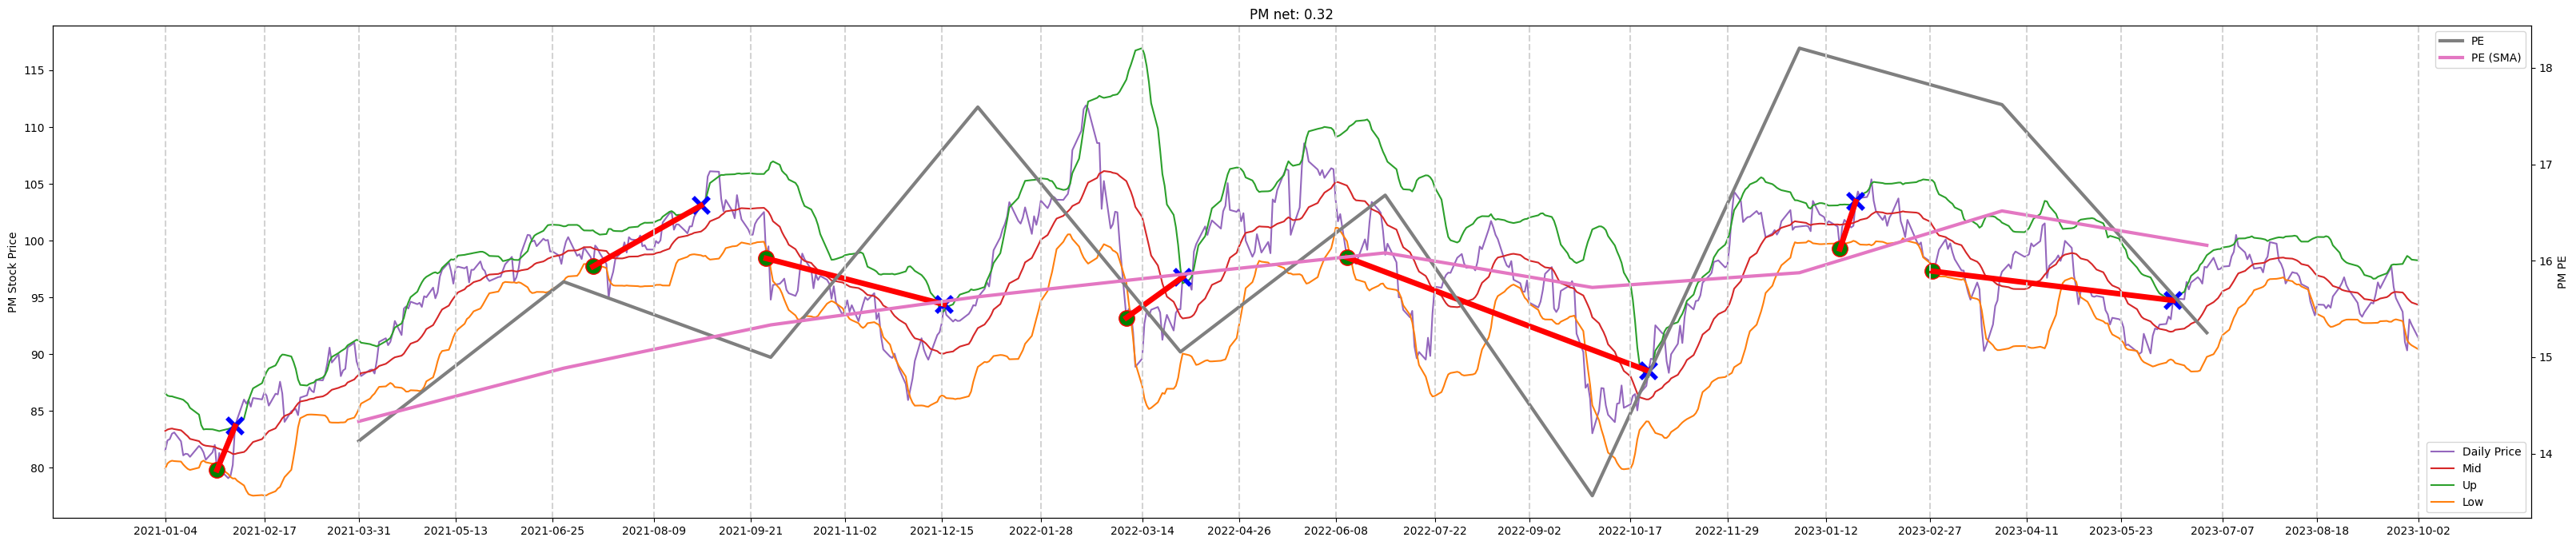

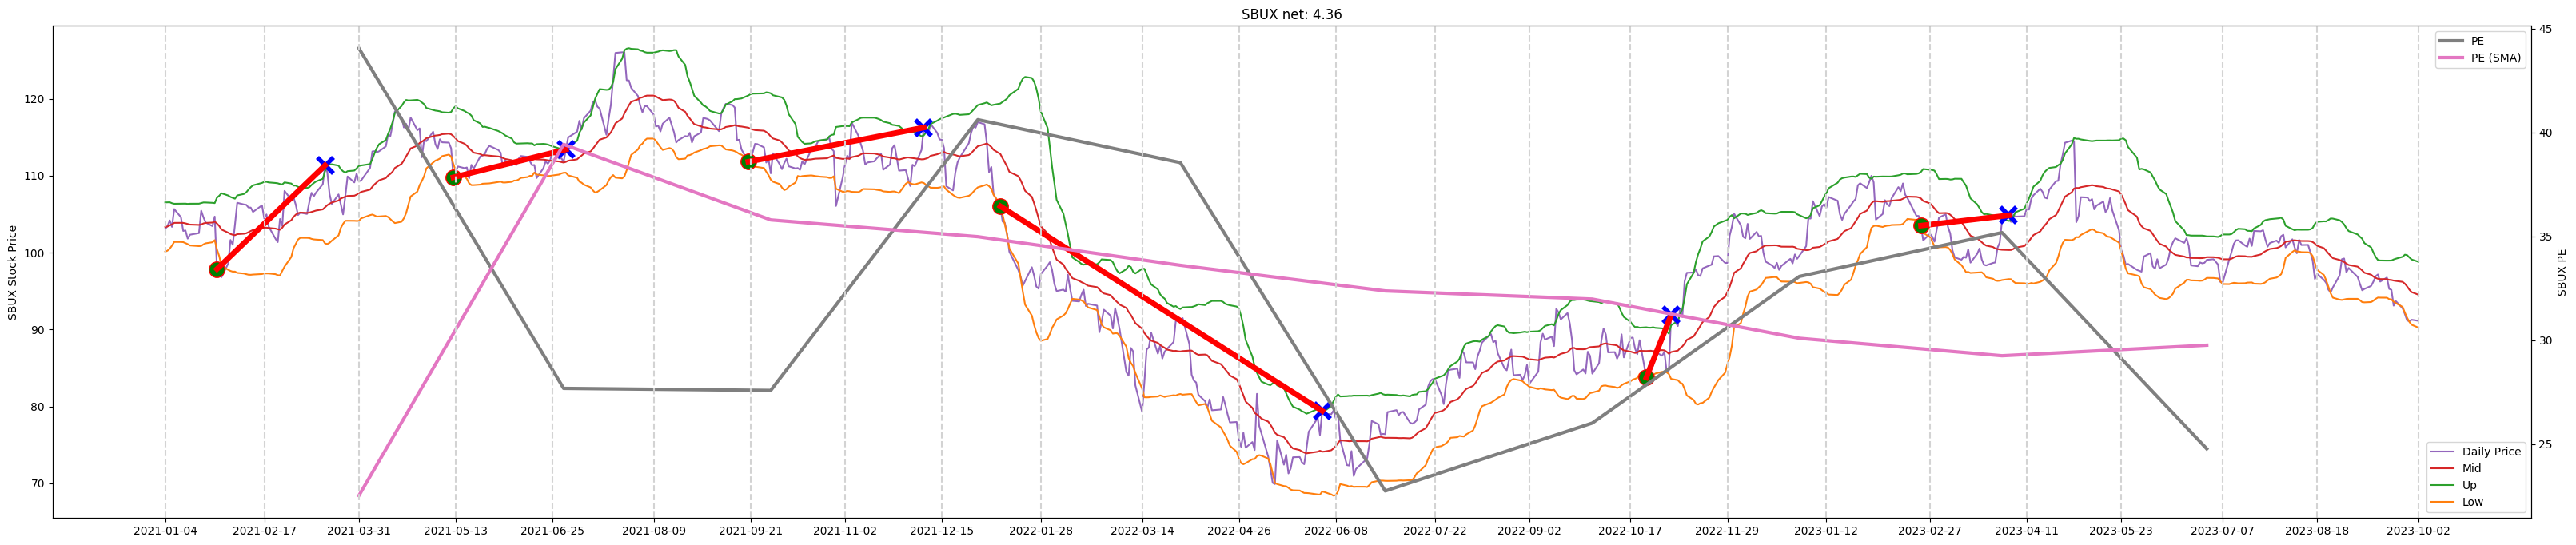

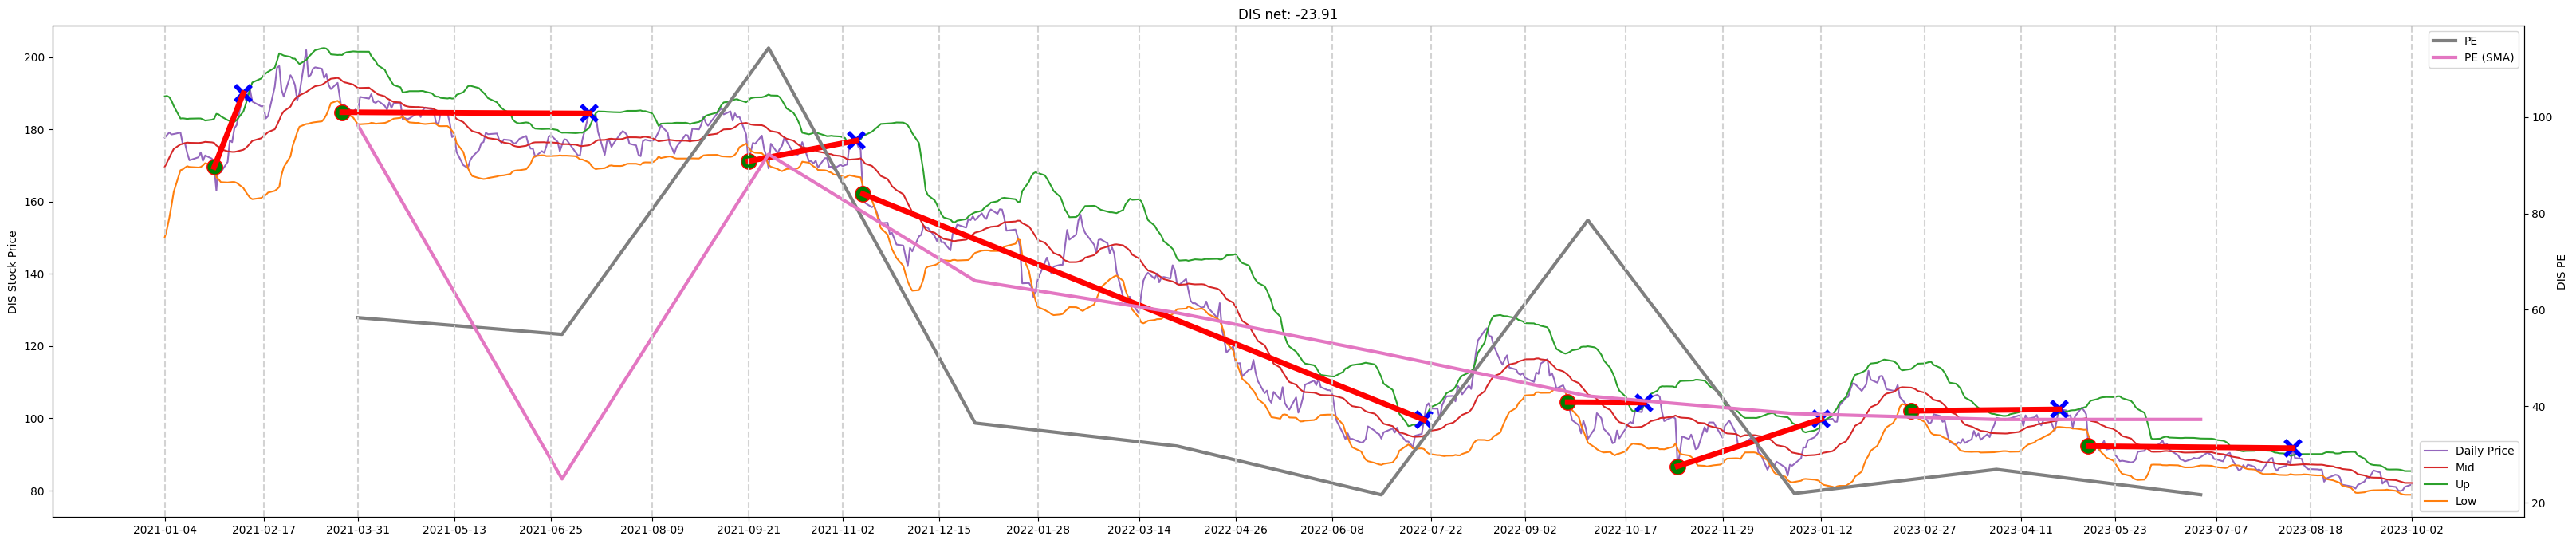

In [81]:
for symbol in symbols:
  plot_graph_enhanced(symbol)

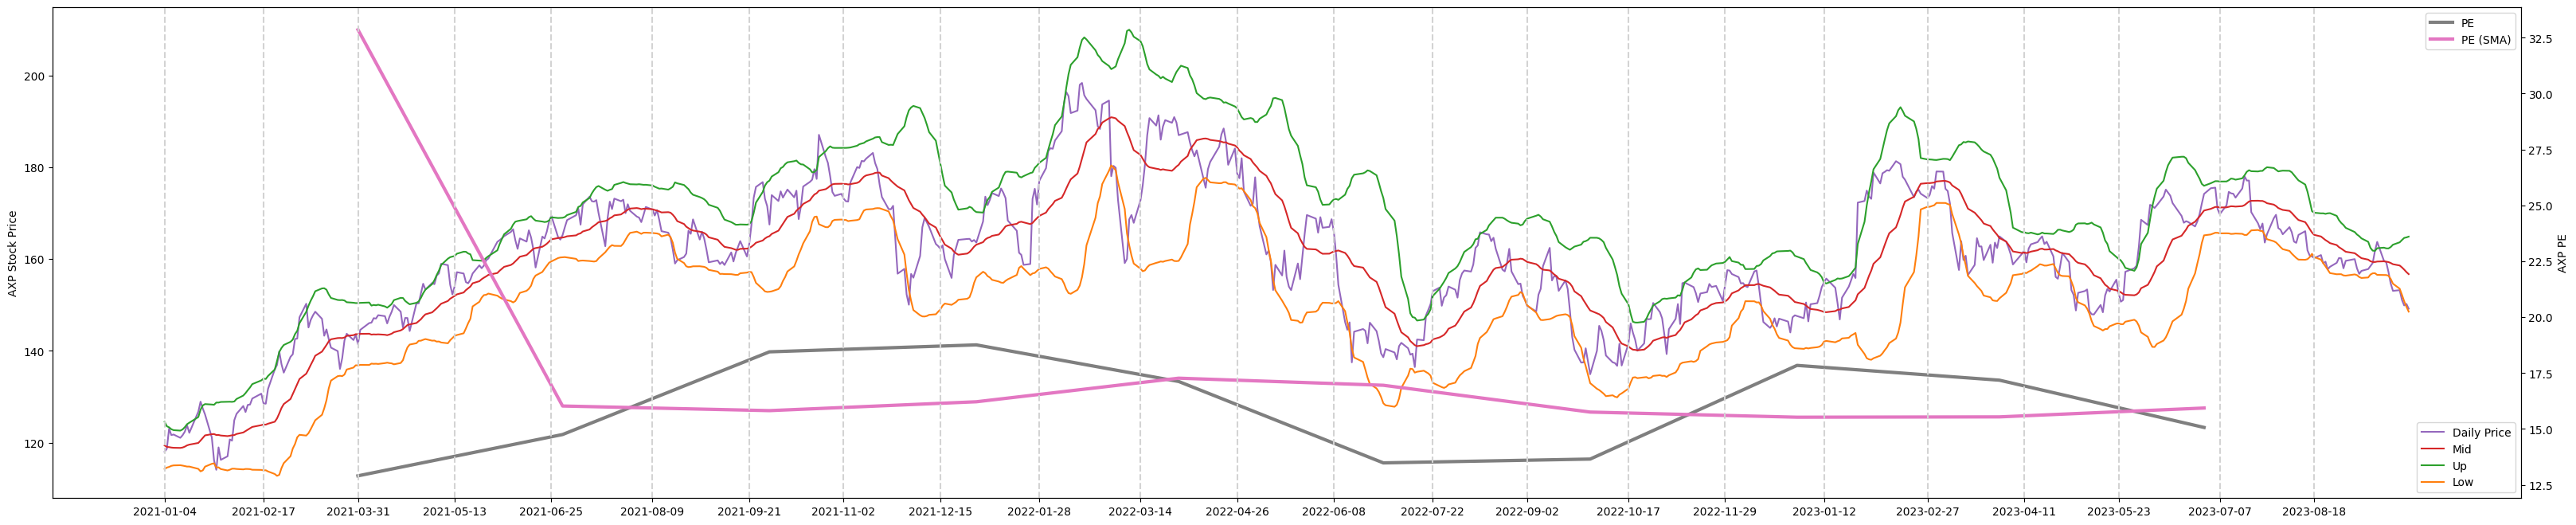

In [ ]:
plot_graph('AXP','2021-01-01')

In [ ]:
df = tsdaily_dfs['AMZN'].copy()
df.head(2)

1. open  2. high  3. low  4. close  5. volume
1999-11-01    68.06    71.88   66.31     69.13   12824100
1999-11-02    69.75    70.00   65.06     66.44   13243200

In [ ]:
tsdaily_df = df.copy()
tsdaily_df = tsdaily_df.sort_index(ascending=False)
tsdaily_df['TP'] = (tsdaily_df['2. high']+tsdaily_df['3. low']+tsdaily_df['4. close'])/3
tsdaily_df['S.D.'] = tsdaily_df['TP']
tsdaily_df['SMA'] = tsdaily_df['TP']
ctr = 0
for idx, row in tsdaily_df.iterrows():
  try:
    tsdaily_df.iloc[ctr,6] = tsdaily_df.iloc[ctr:ctr+20,5].std()
    tsdaily_df.iloc[ctr,7] = tsdaily_df.iloc[ctr:ctr+20,5].mean()
  except:
    print(ctr)
    break
  ctr += 1
tsdaily_df = tsdaily_df.sort_index()
tsdaily_df['BOLU'] = tsdaily_df['SMA'] + 2*tsdaily_df['S.D.']
tsdaily_df['BOLD'] = tsdaily_df['SMA'] - 2*tsdaily_df['S.D.']

In [ ]:
tsdaily_df

1. open   2. high  3. low  4. close  5. volume          TP  \
1999-11-01    68.06   71.8800   66.31     69.13   12824100   69.106667   
1999-11-02    69.75   70.0000   65.06     66.44   13243200   67.166667   
1999-11-03    68.19   68.5000   65.00     65.81   10772100   66.436667   
1999-11-04    67.19   67.1900   61.00     63.06   16759200   63.750000   
1999-11-05    64.75   65.5000   62.25     64.94   11091400   64.230000   
...             ...       ...     ...       ...        ...         ...   
2023-09-25   129.36  131.7800  128.77    131.27   46017825  130.606667   
2023-09-26   130.12  130.3900  125.28    125.98   73048207  127.216667   
2023-09-27   125.76  127.4800  124.13    125.98   66553449  125.863333   
2023-09-28   124.04  126.5801  123.04    125.98   54554968  125.200033   
2023-09-29   128.20  129.1500  126.32    127.12   62411730  127.530000   

                S.D.         SMA        BOLU        BOLD  
1999-11-01       NaN   69.106667         NaN         NaN  
1999-11-02  1.371787   68.136667   70.880241   65.393092  
1999-11-03  1.379940   67.570000   70.329879   64.810121  
1999-11-04  2.217564   66.615000   71.050127   62.179873  
1999-11-05  2.196779   66.138000   70.531557   61.744443  
...              ...         ...         ...         ...  
2023-09-25  4.240368  137.142173  145.622910  128.661437  
2023-09-26  4.708139  136.854007  146.270285  127.437728  
2023-09-27  5.293630  136.425507  147.012768  125.838246  
2023-09-28  5.855212  135.941008  147.651432  124.230584  
2023-09-29  6.137186  135.454200  147.728572  123.179828  

[6017 rows x 10 columns]

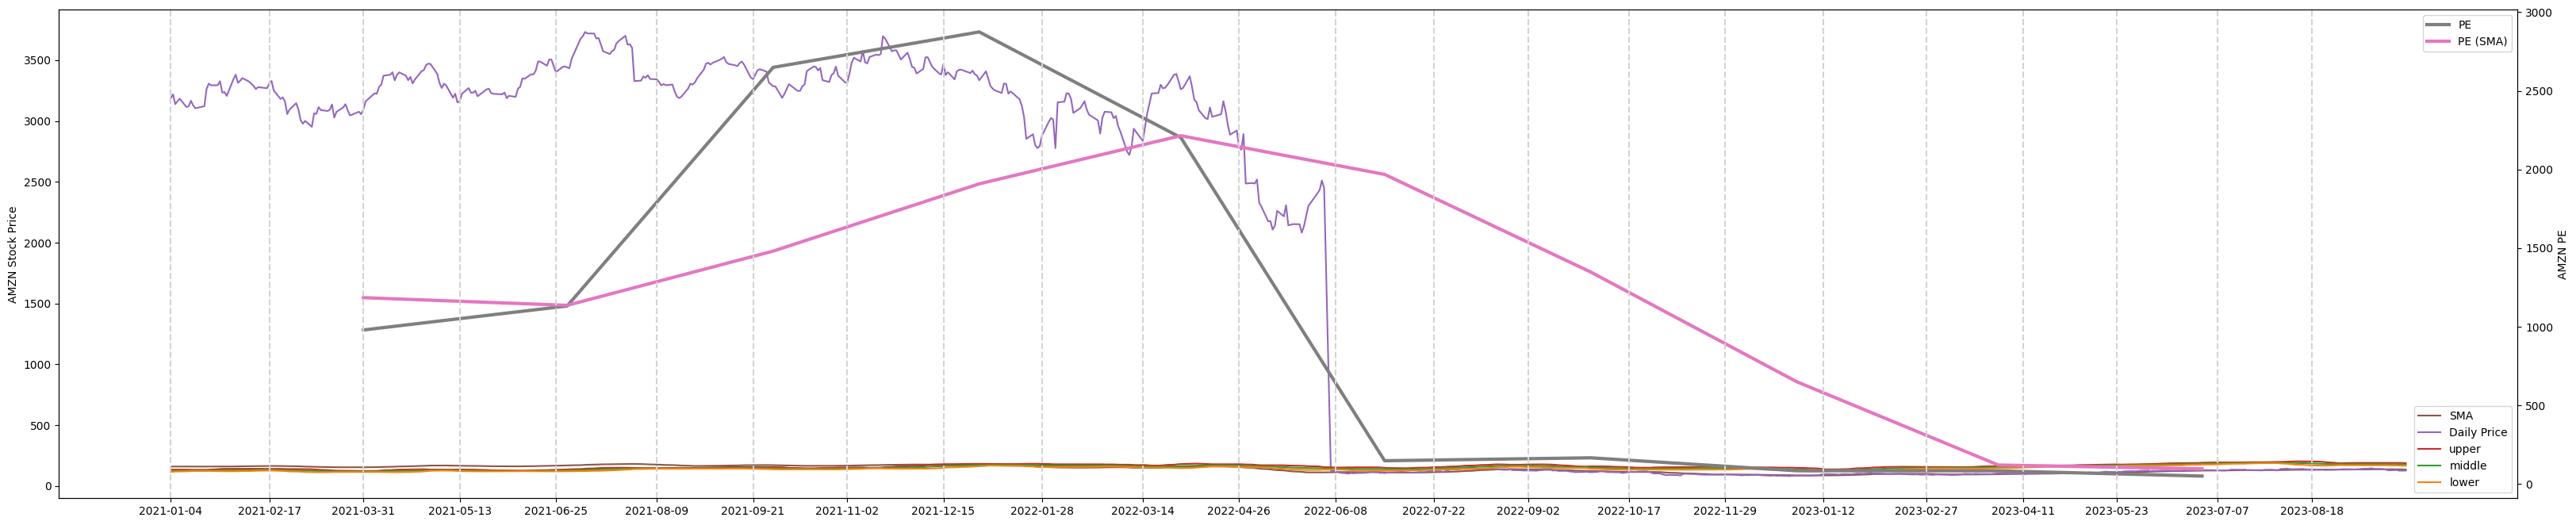

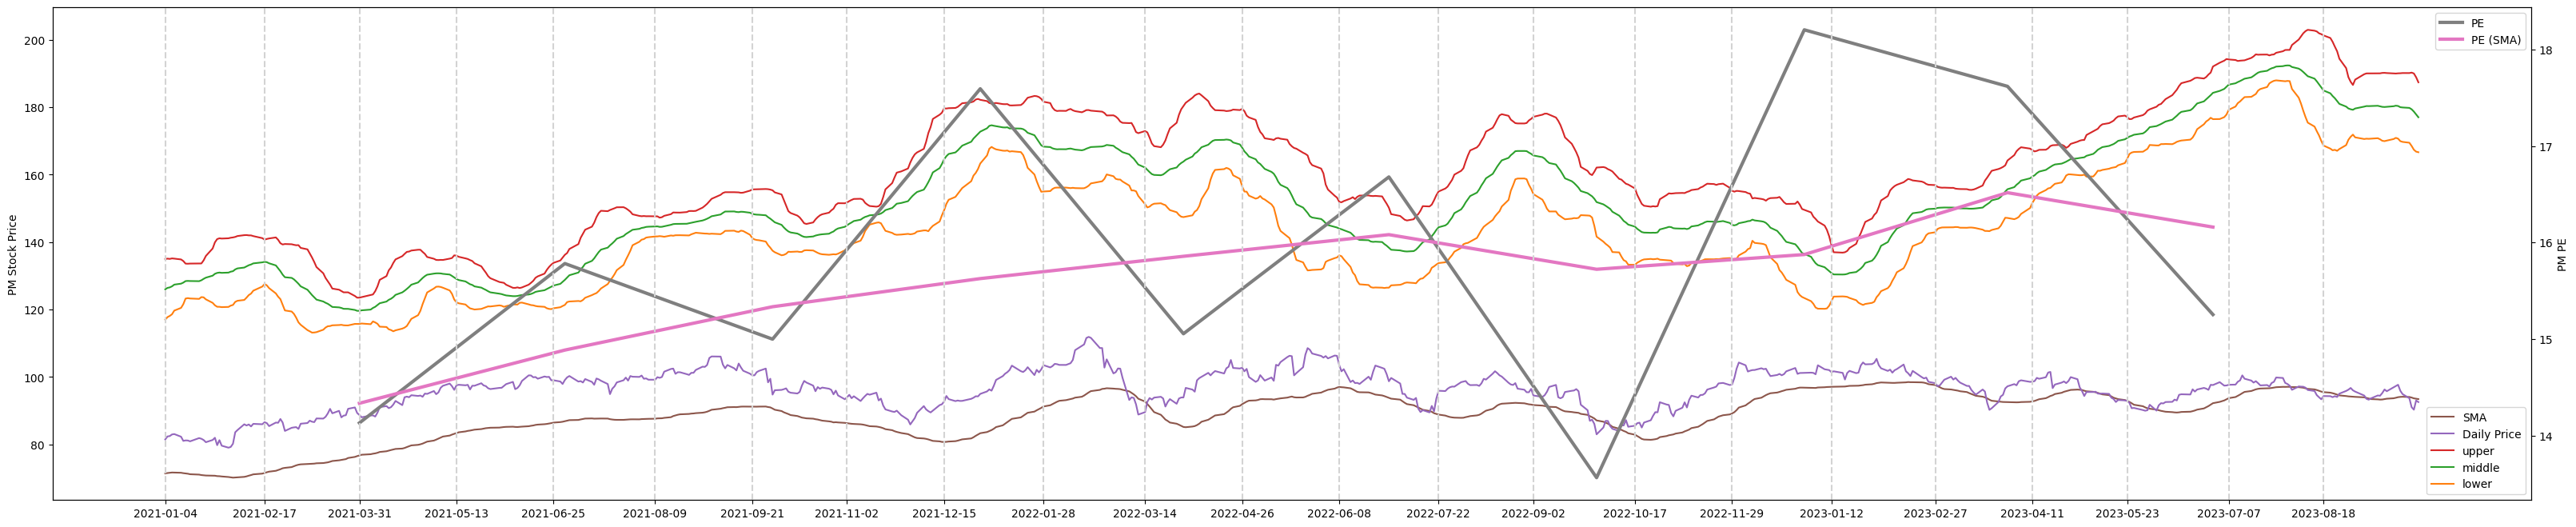

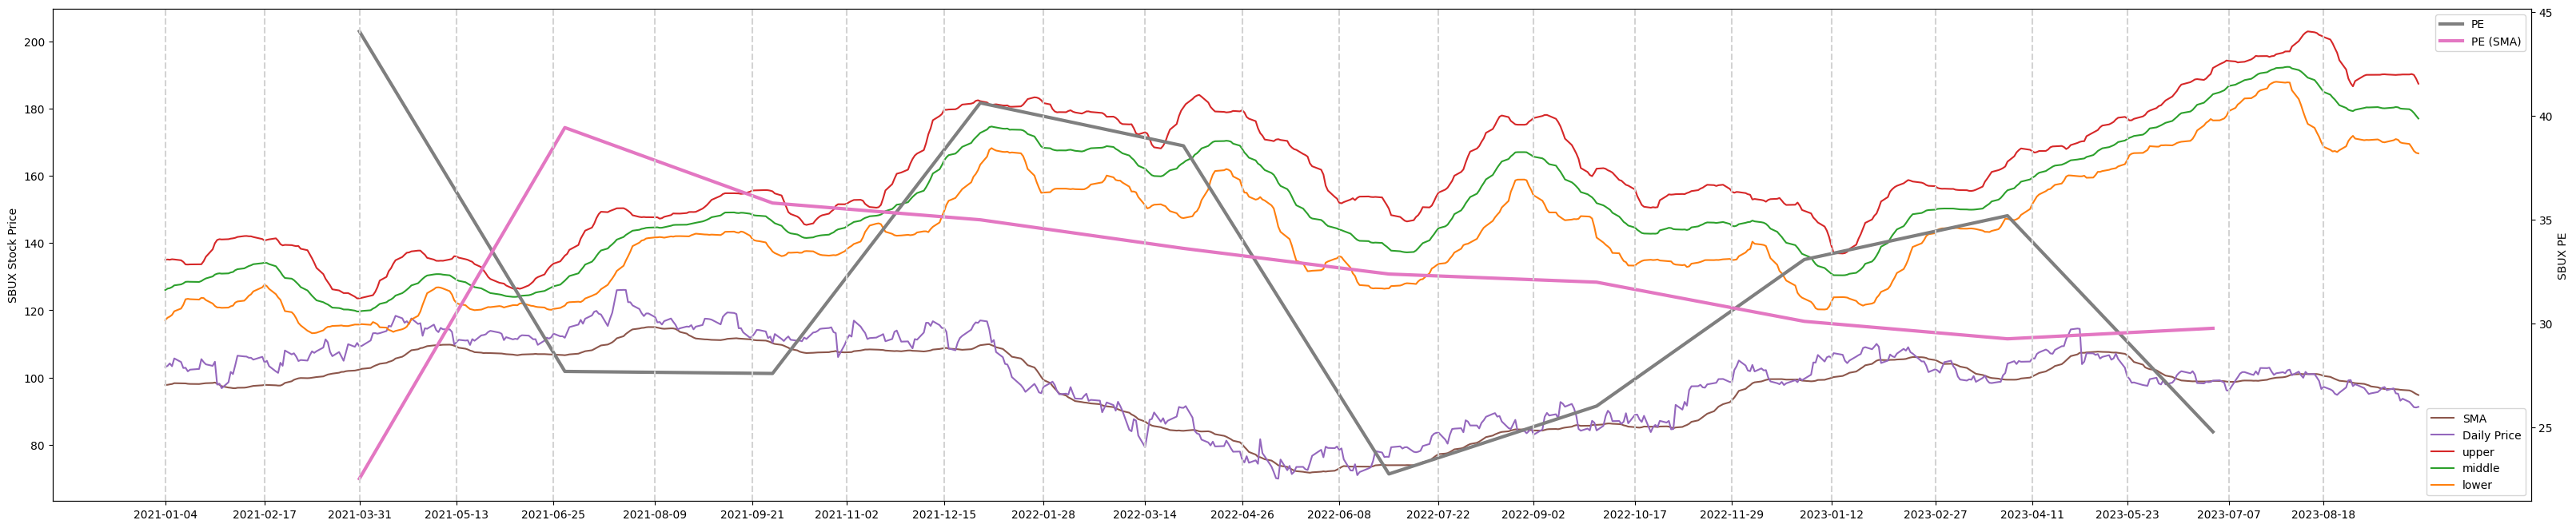

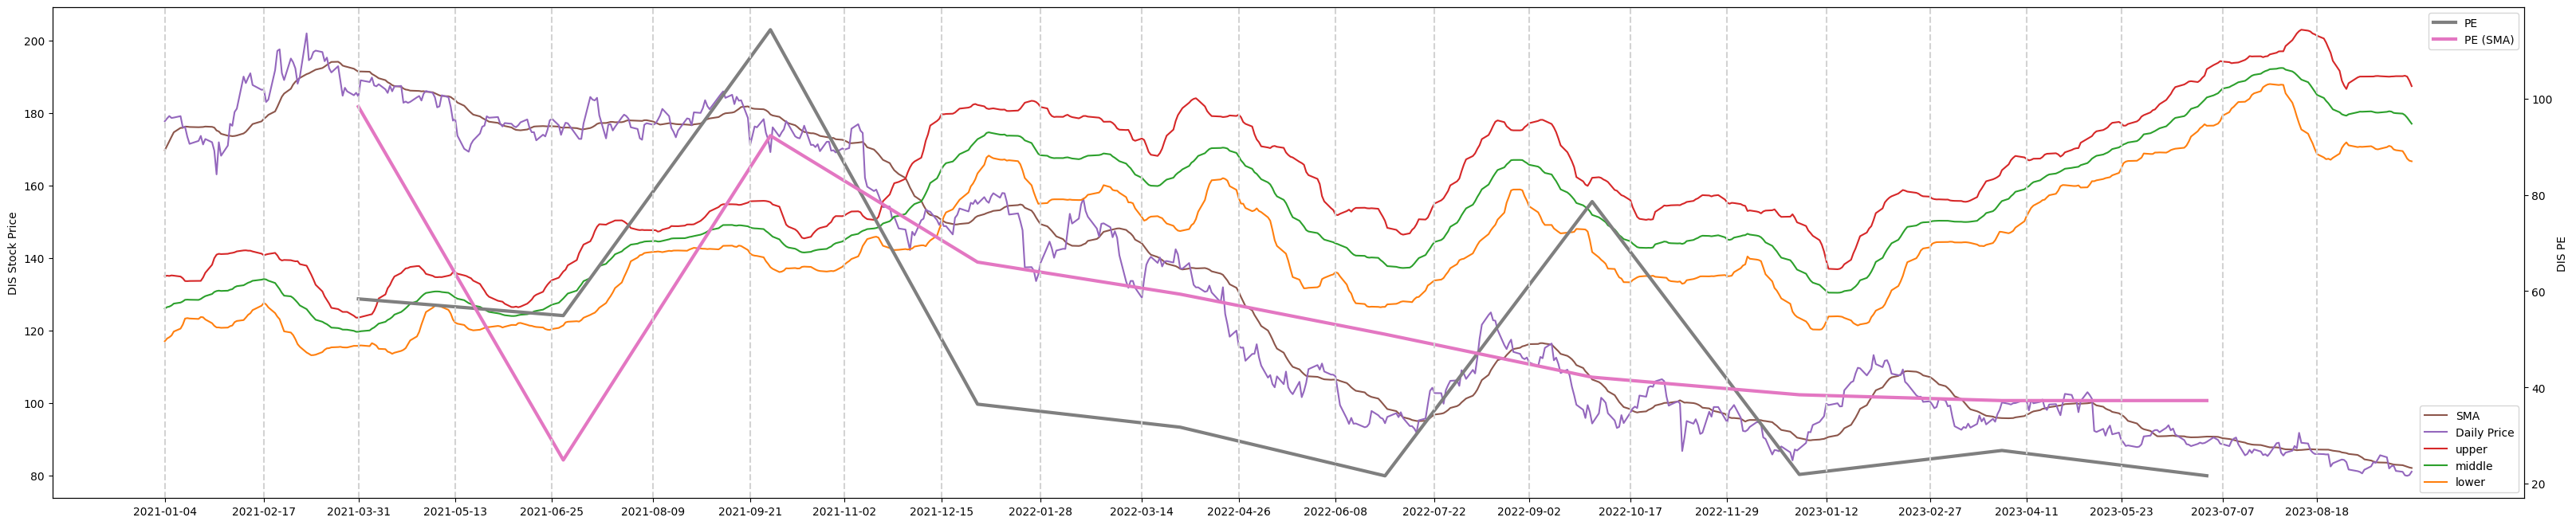

In [ ]:
for sym in symbols:
  plot_graph(sym)

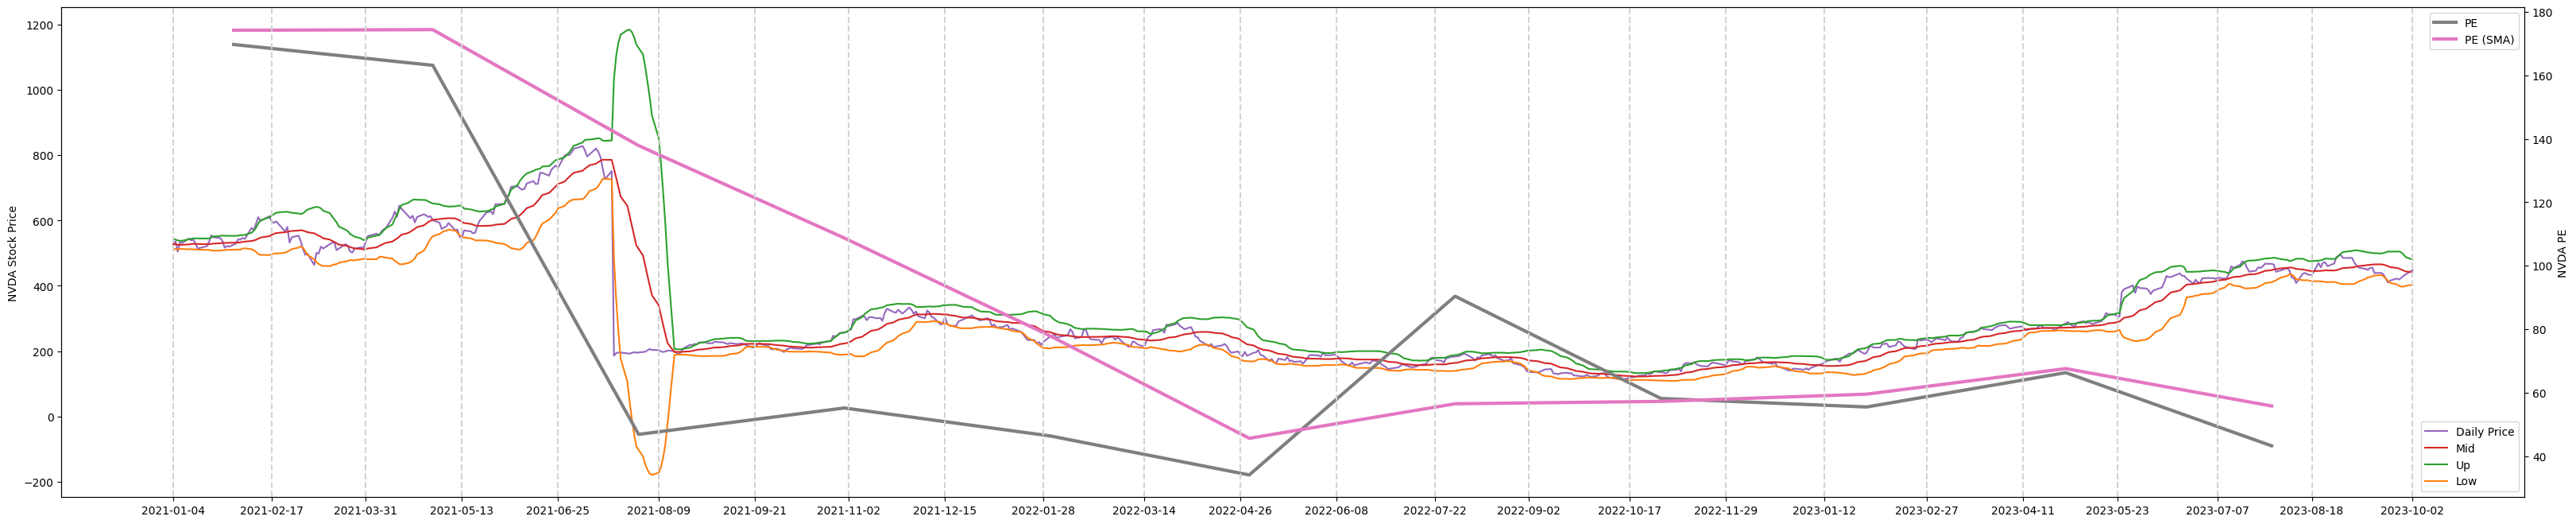

In [37]:
plot_graph('NVDA')